In [1]:
from GimnTools.ImaGIMN.gimnRec.reconstructors.line_integral_reconstructor import line_integral_reconstructor
from GimnTools.ImaGIMN.gimnRec.reconstructors.system_matrix_reconstruction2 import reconstructor_system_matrix_cpu
from GimnTools.ImaGIMN.gimnRec.reconstructors.rotation_reconstruction import rotation_reconstructor
from GimnTools.ImaGIMN.processing.interpolators.reconstruction import beta_spline_interpolation, bilinear_interpolation, nearest_neighbor_interpolation
from GimnTools.ImaGIMN.gimnRec.reconstruction_filters import ramLak
from GimnTools.ImaGIMN.gimnRec.projectors import radon_m, projector, direct_radon

from skimage.transform import resize
from skimage.data import shepp_logan_phantom, horse
import matplotlib.pyplot as plt
import scipy.io
import numpy as np 
from copy import deepcopy 
from pathlib import Path

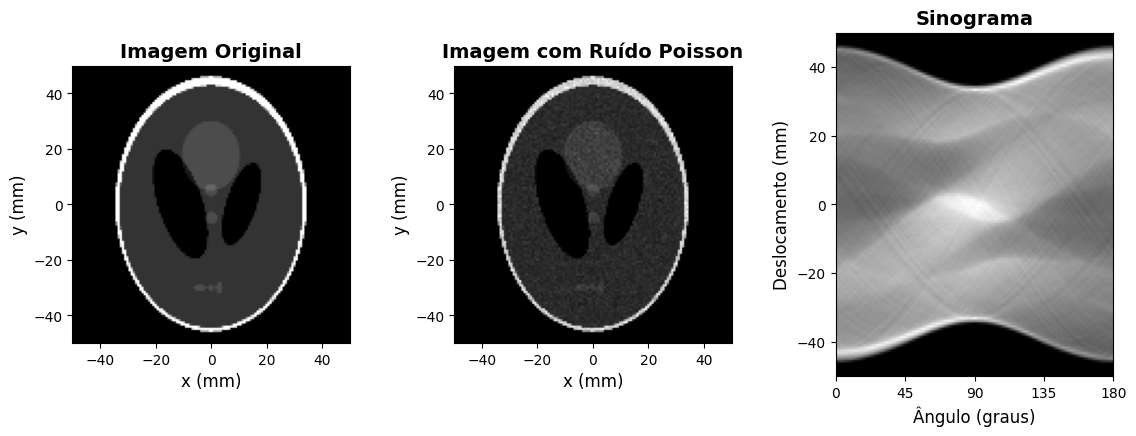

In [2]:

#==========================================================
#                       Gerar Imagens
#==========================================================

m = 128
n = 128

# Gerar a imagem fantoma de Shepp-Logan
original_image = shepp_logan_phantom()
# original_image = horse()

# Redimensionar a imagem para m x n usando interpolação
resized_image = resize(original_image, (m, n), anti_aliasing=False)

# Adicionar ruído Poisson
# Primeiro, normalizar e escalar a imagem para valores adequados para o ruído
# (O ruído Poisson é proporcional à intensidade do sinal)
#quanto maior o noiser maior o ruido
noiser = 200
resized_image = resized_image * noiser
noisy_image = np.random.poisson(resized_image).astype(np.float64)



#==========================================================
#                       Gerar Sinogrma
#==========================================================

number_of_slices = 1
number_of_angles = 180
angles = np.linspace(0, 180, number_of_angles, endpoint=True)
sinogram = direct_radon(noisy_image, angles)
stack = [sinogram for _ in range(number_of_slices)]
stack = np.asarray(stack)

plt.figure(figsize=(12, 5))

# Imagem Original
plt.subplot(1, 3, 1)
plt.imshow(resized_image, cmap='gray', extent=[-50, 50, -50, 50], origin='upper')
plt.title('Imagem Original', fontsize=14, fontweight='bold')
plt.xlabel('x (mm)', fontsize=12)
plt.ylabel('y (mm)', fontsize=12)
plt.xticks(np.arange(-40, 41, 20), fontsize=10)
plt.yticks(np.arange(-40, 41, 20), fontsize=10)
plt.grid(False)

# Imagem com Ruído
plt.subplot(1, 3, 2)
img = plt.imshow(noisy_image, cmap='gray', extent=[-50, 50, -50, 50], origin='upper')
plt.title('Imagem com Ruído Poisson', fontsize=14, fontweight='bold')
plt.xlabel('x (mm)', fontsize=12)
plt.ylabel('y (mm)', fontsize=12)
plt.xticks(np.arange(-40, 41, 20), fontsize=10)
plt.yticks(np.arange(-40, 41, 20), fontsize=10)
plt.grid(False)

# Sinograma
plt.subplot(1, 3, 3)
img_sino = plt.imshow(sinogram, cmap='gray', extent=[0, 180, -50, 50], 
                     aspect='auto', origin='upper')
plt.title('Sinograma', fontsize=14, fontweight='bold')
plt.xlabel('Ângulo (graus)', fontsize=12)
plt.ylabel('Deslocamento (mm)', fontsize=12)
plt.xticks(np.arange(0, 181, 45), fontsize=10)
plt.yticks(np.arange(-40, 41, 20), fontsize=10)
plt.grid(False)

# Ajustes finais
plt.tight_layout(pad=3.0)
plt.savefig('comparacao_imagens.png', dpi=300, bbox_inches='tight')
plt.show()

Processing - iteration: 5	subset: 32
slice:  0


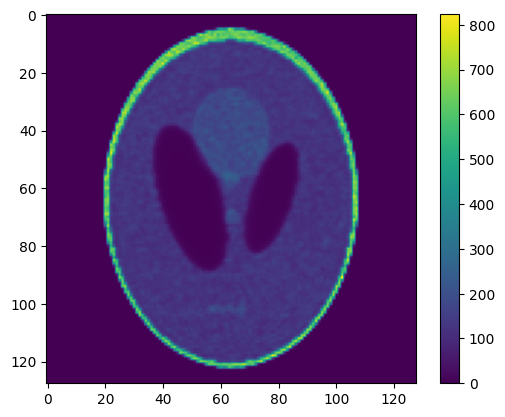

Casting complex values to real discards the imaginary part


In [3]:
#==========================================================
#                 Reconstruir Line Integral
#==========================================================
#para este deve ser slice/bins/angle
angles_m1 = np.linspace(0, 180, number_of_angles, endpoint=True)
# angles_sm = np.linspace(180,0 , number_of_angles, endpoint=False)

reconstructor = line_integral_reconstructor(stack)
# recon_osem_li = reconstructor.osem(iterations,subsets, angles_m1, verbose=False)
# recon_mlem_li = reconstructor.mlem(iterations*subsets, angles_m1, verbose=False)
# recon_fbp_li = reconstructor.fbp( ramLak, angles)
# reconstructor.set_sinogram(stack)

iterations = [5] #1, 3, 5, 7, 9, 11
subsets = [32] #2, 4, 8, 16
pilha = []

for i in range(stack.shape[0]):
    for iter in iterations:
        for subset in subsets:
            print(f'Processing - iteration: {iter}\tsubset: {subset}')
            sino = stack[i:i+1, :, :]

            reconstructor.set_sinogram(sino)
            # Cria o dicionário com a estrutura especificada
            recon = {}
            recon["iterative_method"] = "OSEM/MLEM"
            recon["iteration"] = iter
            recon["subset"] = subset
            recon["total_iterations"] = iter * subset
            recon["sinogram"] = i + 1
            recon ["image_OSEM"] = reconstructor.osem(iter, subset, angles_m1, verbose=True, debug=0)
            recon ["image_MLEM"] = reconstructor.mlem(iter * subset, angles_m1)   
            recon["analytic_method"] = "FBP"
            recon["fbp_image"] = reconstructor.fbp(ramLak, angles)
            pilha.append(deepcopy(recon))

        # recon["method"] = "analithic-FBP"
        # recon["fbp_image"] = reconstructor.fbp(ramLak,angles)
        # stack.append(deepcopy(recon))

image x bins: 128 sinogram radial bins: 128 sinogram angles: 180
iterations:  5  subsets:  32
sino shape:  (1, 180, 128)
slice :  0
Iteration- 1
Iteration- 2
Iteration- 3
Iteration- 4
Iteration- 5
0
1
2
3
4


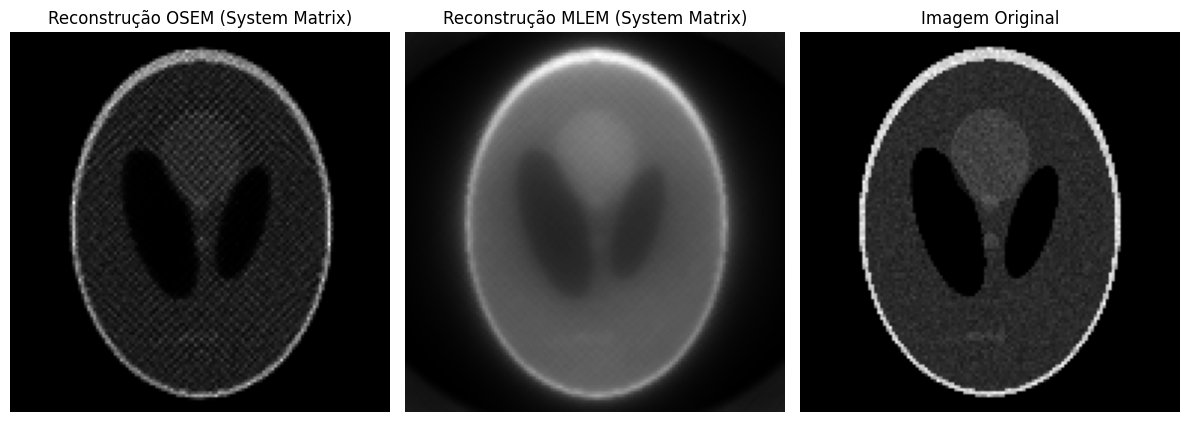

In [4]:

# ==========================================================
#                 Reconstruir Line System Matrix
# ==========================================================

# neste cara os angulos tem que ser invertidos linspace(180,0)
# Para este cara deve ser Slice/Angle/bins
angles_sm = np.linspace(180,0 , number_of_angles, endpoint=False)
stk = np.transpose(stack, (0, 2, 1)) 

iterations = 5 #1, 3, 5, 7, 9, 11
subsets = 32 #2, 4, 8, 16

reconstructor = reconstructor_system_matrix_cpu(stk)
recon_osem_sm = reconstructor.osem(iterations,subsets, angles_sm, show_images=False)
recon_mlem_sm = reconstructor.mlem(iterations, angles_sm)



plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title('Reconstrução OSEM (System Matrix)')
plt.imshow(recon_osem_sm[0], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Reconstrução MLEM (System Matrix)')
plt.imshow(recon_mlem_sm[0], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Imagem Original')
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.tight_layout()



Casting complex values to real discards the imaginary part


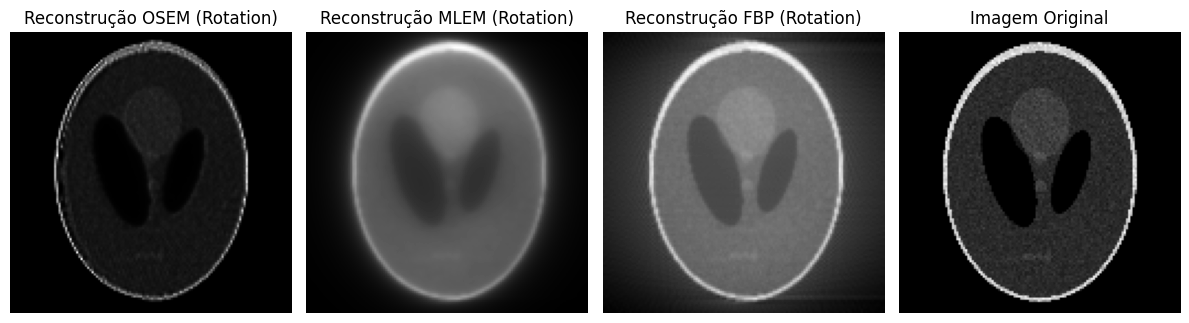

In [5]:
#==========================================================
#                 Reconstruir Rotation
#==========================================================


##sino = np.asarray([sino[sino.shape[0]//2]]) # Select the middle slice for reconstruction
reconstructor = rotation_reconstructor()
reconstructor.set_sinogram(stack)
#reconstructor.set_sinogram(sino) 

iterations = 5
subsets = 32 #2, 4, 8, 16

angles_here = angles+180
recon_osem_rot = reconstructor.osem(iterations,subsets, bilinear_interpolation, angles=angles_here, verbose=False)
recon_mlem_rot = reconstructor.mlem(iterations, bilinear_interpolation, angles=angles_here, verbose=False)
recon_fbp_rot= reconstructor.fbp(bilinear_interpolation, ramLak, angles=angles_here)


plt.figure(figsize=(12, 8))
plt.subplot(1, 4, 1)
plt.title('Reconstrução OSEM (Rotation)')
plt.imshow(recon_osem_rot[0], cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.title('Reconstrução MLEM (Rotation)')
plt.imshow(recon_mlem_rot[0], cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title('Reconstrução FBP (Rotation)')
plt.imshow(recon_fbp_rot[0], cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title('Imagem Original')
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.tight_layout()

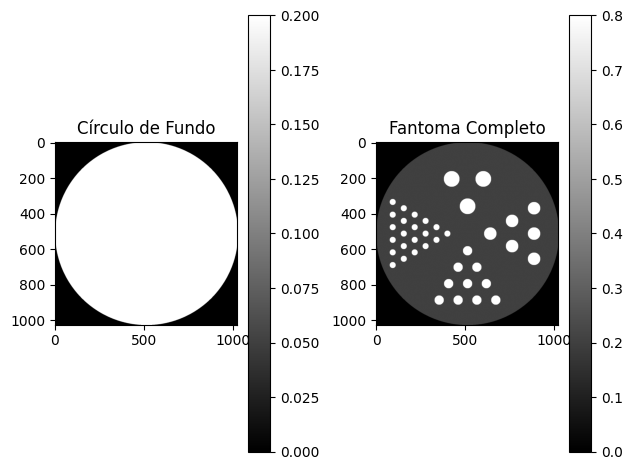

In [1]:
from GimnTools.ImaGIMN.phantoms.derenzzo import DerenzoPhantomSlice



from matplotlib import pyplot as plt
# Teste do código adaptado
radius = 29.0 / 2
num_sections = 4
well_counts = (6, 6, 10, 15)
well_diameters = (2.5, 2.0, 1.5, 1.0)
well_separations = (2.5, 2.0, 1.5, 1.0)
section_offsets = (0.00000001, 0.01, 0.01, 0.1)  # Offset personalizado para cada seção
circle_value = 0.2
well_value = 0.8
image_size = 1024

my_phantom = DerenzoPhantomSlice(radius, num_sections, well_counts, well_diameters, well_separations, section_offsets,
                            image_size=image_size, circle_value=circle_value, well_value=well_value)


#my_phantom.save_image('derenzo_phantom_with_offsets.png')

# Obter a matriz da imagem contendo apenas o círculo de fundo
circle_image_matrix = my_phantom.draw_only_circle()

# Plotar a primeira imagem
plt.subplot(1, 2, 1)
plt.imshow(circle_image_matrix, cmap='gray')
plt.title('Círculo de Fundo')
plt.colorbar()

# Obter a matriz completa do fantoma
phantom_matrix = my_phantom.get_image_matrix()

# Plotar a segunda imagem
plt.subplot(1, 2, 2)
plt.imshow(phantom_matrix, cmap='gray')
plt.title('Fantoma Completo')
plt.colorbar()

# Ajustar layout para exibir as imagens lado a lado
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Imagem Aleatória')

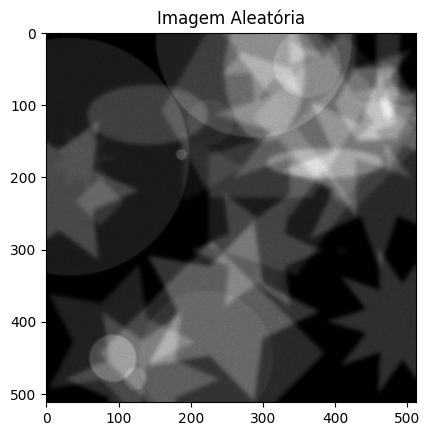

In [1]:
from GimnTools.ImaGIMN.phantoms.random import generate_random_image
import matplotlib.pyplot as plt
import numpy as np
img = generate_random_image(512,37)


plt.imshow(img, cmap='gray')
plt.title('Imagem Aleatória')   